In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.linalg import eigvals, eig, expm, sinm, cosm, logm
from numpy import random
from pybads import BADS
from scipy.stats import bernoulli
import pandas as pd

In [3]:
'''Defining operators to be used in the definition of the Hamiltonian'''

sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1.0j],[1.0j,0]])
sz = np.array([[1,0],[0,-1]])
id_mat = np.eye(2)

def sp():
    return (sx + 1.0j* sy)/2

def sm():
    return (sx - 1.0j* sy)/2

def id_prod(k):
    return np.eye(2**k)

def sz1kron(Ns,k):
    return np.kron(np.kron(id_prod(k-1),sz),id_prod(Ns-k))

def sz2kron(Ns,k):
    temp = np.kron(sz,sz)
    return np.kron(np.kron(id_prod(k-2),temp),id_prod(Ns-k))

def sz3kron(Ns,k):
    temp = np.kron(sp(),np.kron(sz,sm()))
    return np.kron(np.kron(id_prod(k-2),temp),id_prod(Ns-k-1))

def sz4kron(Ns,n,m):
    tempn = np.kron(sp(),sm())
    tempm = np.kron(sm(),sp())
    
    return np.kron(np.kron(np.kron(np.kron(id_prod(n-2),tempn), id_prod(m-n-2)), tempm), id_prod(Ns-m))

diff_term = np.kron(sz,np.eye(2)) - np.kron(np.eye(2),sz)

def mass_ham(N):
    mat = 0
    for i in range(1,N+1):
        mat += ((-1)**i)*(sz1kron(2*N,2*i-1) + sz1kron(2*N,2*i))/2 + id_prod(2*N)
    return mat

def kin_ham(N):
    mat = 0
    for i in range(1,N):
        temp = sz3kron(2*N,2*i) + sz3kron(2*N, 2*i+1)
        mat += (temp + np.conjugate(np.transpose(temp)))*(-0.5)
    return np.real(mat)

def el_ham(N):
    mat = 0
    for i in range(1,N):
        mat += (N-i)*(id_prod(2*N) - sz2kron(2*N,2*i))*(3./16)
    for n in range(1,N-1):
        for m in range(n+1,N):
            mat += (1./16)*(N-m)*np.kron(np.kron(np.kron(np.kron(id_prod(2*n-2),diff_term),id_prod(2*m-2*n-2)), diff_term), id_prod(2*N-2*m))
            temp = 0.5*(N-m)*sz4kron(2*N,2*n,2*m)
            mat += np.real(temp + np.conjugate(np.transpose(temp)))
    return mat

def chem_ham(N):
    mat = 0
    for i in range(1,N+1):
        mat += 0.25*(sz1kron(2*N,2*i-1) + sz1kron(2*N,2*i))
    #hmat = mass_ham(N) + kin_ham(N) +  (1./x)*el_ham(N) - mu*mat
    return mat

def chi_ham(N):
    mat = 0
    for i in range(1,N+1):
        mat += 0.5*((-1)**i)*(sz1kron(2*N,2*i-1) + sz1kron(2*N,2*i))
    return mat

def bar_num(N):
    mat = 0
    for i in range(1,2*N+1):
        mat += 0.25*sz1kron(2*N,i)
    return mat

def Q_xyz(Ns):
    tempn = np.kron(sp(),sm())
    tempm = np.kron(sm(),sp()) 
    mat_x = 0
    mat_y = 0
    mat_z = 0
    Q_mat = []
    for i in range(1,Ns+1):
        mat_x += np.kron(id_prod(2*i-2),np.kron(tempn,id_prod(2*Ns-2*i)))
        mat_y += np.kron(id_prod(2*i-2),np.kron(tempm,id_prod(2*Ns-2*i)))
        mat_z += sz1kron(2*Ns,2*i-1) - sz1kron(2*Ns,2*i)
    
    Q_mat.append(0.5*(mat_x + np.conjugate(np.transpose(mat_x))))
    Q_mat.append( 0.5*1.0j*(mat_y - np.conjugate(np.transpose(mat_y))) )
    Q_mat.append( 0.25*mat_z )
    
    return np.array(Q_mat)

In [5]:
'''Defining the Hamiltonian'''

N = 2
m = 0.5
x = 1.0
T = 0.5 #Temperature

num_op = bar_num(N)
chi_op = chi_ham(N)
el_op = el_ham(N)


mass_mat = mass_ham(N)
kin_mat = kin_ham(N)
el_mat = el_ham(N)
chem_mat = chem_ham(N)

h_1 = m*mass_mat + kin_mat +  (1./x)*el_mat

In [6]:
'''Turn a computational basis state label |j> to the corresponding density matrix |j><j|'''

def key_to_mat(label):
    vec = 1.0
    for i in label:
        if i == '0':
            vec = np.kron(vec,np.array([1,0]))
        elif i=='1':
            vec = np.kron(vec,np.array([0,1]))
        else:
            return print('Wrong label')
    return np.outer(vec,np.conjugate(vec))

In [8]:
labels = np.array(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY',
       'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'])

In [11]:
''' Changes Pauli labels to matrix '''

def label_to_matrix(label):
    mat = 1.0
    for i in label:
        if i == 'X':
            mat = np.kron(mat,sx)
        elif i =='Y':
            mat = np.kron(mat,sy)
        elif i =='Z':
            mat = np.kron(mat,sz)
        elif i=='I':
            mat = np.kron(mat,np.eye(2))
        else:
            return print('Wrong label')
    return mat

In [12]:
'''Takes a density matrix and applies a error channel on qubits i and j'''

def error_channel(rho,error_list,i,j,Nq):
    
    mat = np.zeros((2**Nq,2**Nq),dtype='complex64')
    
    for label, prob in error_list:
        new_label = 'I'*i + label[0] + 'I'*(j-i-1) + label[1] + 'I'*(Nq-j-1)
        pauli_mat = label_to_matrix(new_label)
   
        mat += prob*np.matmul(np.matmul(pauli_mat,rho),pauli_mat)
    return mat/np.trace(mat)

In [13]:
''' Definition of a noisy/exact unitary on a density matrix'''

def unitary(rho, U, Nq, qubits = None, noise=False):
    rho_prime = U @ rho @ np.conjugate(U.T)
    rho_prime = rho_prime/np.trace(rho_prime)
    if noise == False:
        return rho_prime
    elif len(qubits)== 2 and noise == True:
        return error_channel(rho_prime,error_list,qubits[0],qubits[1],Nq)
    else:
        return 'Noise Channel is defined only for 2 qubit gates'

In [14]:
from qiskit.quantum_info import SparsePauliOp

In [15]:
family1 = SparsePauliOp.from_operator(h_1).group_commuting(qubit_wise=False)[0]

In [16]:
'''Definition of gates '''

def XX_gate(theta,i,j,num_q):
    mat = np.kron(np.eye(2**i),np.kron(sx,np.kron(np.eye(2**(j-i-1)),np.kron(sx,np.eye(2**(num_q-j-1))))))
    return expm(-1.0j*theta*mat)

def rx_gate(theta,i,num_q):
    mat = np.kron(np.eye(2**i),np.kron(sx,np.eye(2**(num_q-i-1))))
    return expm(-0.5j*theta*mat)

def ry_gate(theta,i,num_q):
    mat = np.kron(np.eye(2**i),np.kron(sy,np.eye(2**(num_q-i-1))))
    return expm(-0.5j*theta*mat)

def rz_gate(theta,i,num_q):
    mat = np.kron(np.eye(2**i),np.kron(sz,np.eye(2**(num_q-i-1))))
    return expm(-0.5j*theta*mat)

def ZZ_gate(theta,i,j,num_q):
    mat = np.kron(np.eye(2**i),np.kron(sz,np.kron(np.eye(2**(j-i-1)),np.kron(sz,np.eye(2**(num_q-j-1))))))
    return expm(-1.0j*theta*mat)

def CNOT(i,j,Nq):
    mat1 = np.kron(np.eye(2**i),np.kron(key_to_mat('0'),np.kron(np.eye(2**(j-i-1)),np.kron(np.eye(2),np.eye(2**(Nq-j-1))))))
    mat2 = np.kron(np.eye(2**i),np.kron(key_to_mat('1'),np.kron(np.eye(2**(j-i-1)),np.kron(sx,np.eye(2**(Nq-j-1))))))
    return mat1 + mat2

def hadamard(i,Nq):
    temp = (1./np.sqrt(2))*np.array([[1.,1.],[1.,-1.]])
    mat = np.kron(np.eye(2**i),np.kron(temp,np.eye(2**(Nq-i-1))))
    return mat
    
s_gate = np.array([[1,0],[0,1.0j]])
def S_gate(i,Nq):
    mat = np.kron(np.eye(2**i),np.kron(s_gate,np.eye(2**(Nq-i-1))))
    return mat

def S_dag_gate(i,Nq):
    temp = s_gate.T.conjugate()
    mat = np.kron(np.eye(2**i),np.kron(temp,np.eye(2**(Nq-i-1))))
    return mat

In [17]:
''' Noisy gates needed for trotter time evolution '''

def XZX_noisy_trotter(rho,i,Nq,dt):
    U = CNOT(i,i+2,Nq)
    rho = unitary(rho,U,Nq,[i,i+2],noisy)
    U = XX_gate(-dt/4,i,i+1,Nq) @ hadamard(i+1,Nq)
    rho = unitary(rho,U,Nq,[i,i+1],noisy)
    U = CNOT(i,i+2,Nq)  @ hadamard(i+1,Nq)
    rho = unitary(rho,U,Nq,[i,i+2],noisy)
    return rho

def ZZ_noisy_trotter(rho,i,Nq,dt):
    U = ZZ_gate(-dt*0.1875,i,i+1,Nq) 
    rho = unitary(rho,U,Nq,[i,i+1],noisy)
    return rho

def YZY_noisy_trotter(rho,i,Nq,dt):
    U = CNOT(i,i+2,Nq) @ S_gate(i,Nq) @ S_gate(i+2,Nq)
    rho = unitary(rho,U,Nq,[i,i+2],noisy)
    U = XX_gate(-dt/4,i,i+1,Nq) @ hadamard(i+1,Nq)
    rho = unitary(rho,U,Nq,[i,i+1],noisy)
    U = CNOT(i,i+2,Nq)  @ hadamard(i+1,Nq)
    rho = unitary(rho,U,Nq,[i,i+2],noisy)
    U = S_dag_gate(i,Nq) @ S_dag_gate(i+2,Nq)
    rho = unitary(rho,U,Nq)
    return rho

In [18]:
''' Hamiltonian and time evolution unitary involving only single qubit diagonal gates '''

h_sq = SparsePauliOp(family1.paulis[1:],family1.coeffs[1:]).to_matrix()
def h_sq_trotter(rho,Nq,dt):
    U = expm(-1.0j*h_sq*dt)
    rho = unitary(rho,U,Nq)
    return rho

In [20]:
''' A single trotter step noisy/exact'''

def one_trotter_step(rho,dt):
    rho = XZX_noisy_trotter(rho,0,Nq,dt)
    rho = YZY_noisy_trotter(rho,0,Nq,dt)
    rho = XZX_noisy_trotter(rho,1,Nq,dt)
    rho = YZY_noisy_trotter(rho,1,Nq,dt)

    rho = ZZ_noisy_trotter(rho,0,Nq,dt)

    rho = h_sq_trotter(rho,Nq,dt)
    return rho

In [21]:
t_final = 10.0
dt = 0.1
t_steps = int(t_final/dt + 1)

In [22]:
''' Exact <H_m> expectation value during the dynamics'''

t_exact = np.linspace(0.0,t_final,t_steps)
hm_arr = []
for i in range(t_steps):
    t = t_exact[i]
    init_state = key_to_mat('0011')
    final_state = expm(-1.0j*h_1*t) @ init_state @ expm(1.0j*h_1*t)
    hm_arr.append(np.real(np.trace(mass_mat @ final_state)))

In [23]:
'''Exact trotterization: <H_m> expectation value'''

noisy = False
Nq = 4

dt = 0.25
t_steps_trotter = int(t_final/dt + 1)
t_trotter = np.linspace(0.0,t_final,t_steps_trotter)

hm_arr_trotter = []
init_state = key_to_mat('0011')
hm_arr_trotter.append(np.real(np.trace(mass_mat @ init_state)))
for i in range(t_steps_trotter-1):
    final_state = one_trotter_step(init_state,dt)
    hm_arr_trotter.append(np.real(np.trace(mass_mat @ final_state)))
    init_state = final_state

In [24]:
'''Projection operator for single unit cell (N=2)'''

k_mat = np.diag(np.array([1., 0., 0., 1., 0., -0.5, 1., 0., 0., 1., -0.5, 0., 1., 0., 0., 1.]))

In [25]:
'''Defining the two-qubit depolarizing error channel'''

lam = 0.001 #Strength of depolarizing channel
probs = np.array([1-15*lam/16] + [lam/16]*15)
error_list = list(zip(labels,probs))
print(error_list)

[('II', 0.9990625), ('XI', 6.25e-05), ('YI', 6.25e-05), ('ZI', 6.25e-05), ('IX', 6.25e-05), ('XX', 6.25e-05), ('YX', 6.25e-05), ('ZX', 6.25e-05), ('IY', 6.25e-05), ('XY', 6.25e-05), ('YY', 6.25e-05), ('ZY', 6.25e-05), ('IZ', 6.25e-05), ('XZ', 6.25e-05), ('YZ', 6.25e-05), ('ZZ', 6.25e-05)]


In [26]:
noisy = True
Nq = 4
hm_arr_trotter_noisy = []
hm_arr_trotter_noisy_corrected = []
init_state = key_to_mat('0011')
hm_arr_trotter_noisy.append(np.real(np.trace(mass_mat @ init_state)))
hm_arr_trotter_noisy_corrected.append(np.real(np.trace(mass_mat @ init_state)))
for i in range(t_steps_trotter-1):
    final_state = one_trotter_step(init_state,dt)
    #fsk = k_mat @ final_state @ k_mat/(np.trace(final_state @ k_mat))
    hm_arr_trotter_noisy.append(np.real(np.trace(mass_mat @ final_state)))
    num = np.real(np.trace(final_state @ mass_mat @ k_mat))
    den = np.real(np.trace(final_state @ k_mat))
    hm_arr_trotter_noisy_corrected.append(num/den)
    init_state = final_state

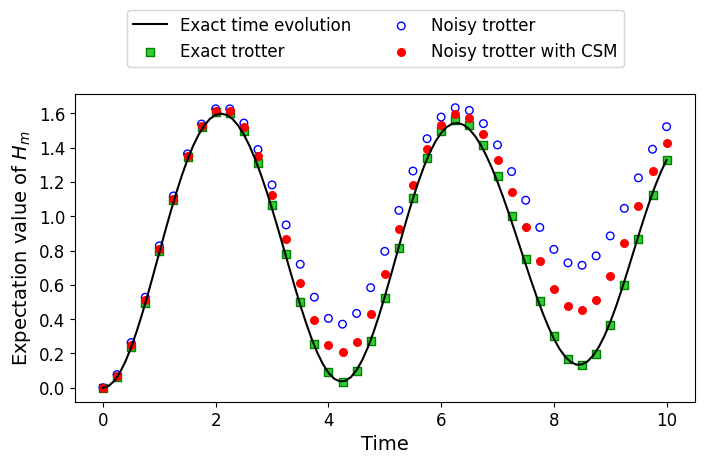

In [34]:
plt.figure(figsize=(8,4))
plt.plot(t_exact,hm_arr,'k',label='Exact time evolution')
plt.scatter(t_trotter,hm_arr_trotter,facecolors='limegreen',marker='s',s=40,label='Exact trotter',edgecolors='g')
plt.scatter(t_trotter,hm_arr_trotter_noisy,s=30,facecolors='none',edgecolors='b',label='Noisy trotter')
plt.scatter(t_trotter,hm_arr_trotter_noisy_corrected,s=30,c='r',label='Noisy trotter with CSM')
plt.legend(fontsize = 12,bbox_to_anchor=(0.9, 1.3), ncol=2)
plt.xlabel('Time',size=14)
plt.ylabel(r'Expectation value of $H_m$',size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [35]:
from scipy.optimize import curve_fit

In [36]:
def model_sigmoid(x, a, b, d):
    return a /(1.0 + np.exp(-b*x)) + d

In [37]:
dt = 0.25
t_steps_trotter = int(t_final/dt + 1)
t_trotter = np.linspace(0.0,t_final,t_steps_trotter)

In [39]:
'''Varying the noise parameter and calculate R(t)'''

noisy = True
Nq = 4

trotter_noisy_ratio = []
lam_list = np.array([0.002*x for x in range(3,20)])

for lam in lam_list:
    probs = np.array([1-15*lam/16] + [lam/16]*15)

    error_list = list(zip(labels,probs))
    print(error_list)

    init_state = key_to_mat('0011')
    t_test = 0

    for i in range(t_steps_trotter):
        final_state = one_trotter_step(init_state,dt) 
        init_state = final_state
        t_test += dt
        print(f'noise strength = {lam}\t time = {t_test}')
    
        trotter_noisy_ratio.append(1./np.real(np.trace(final_state @ k_mat)) - 1)   

[('II', 0.994375), ('XI', 0.000375), ('YI', 0.000375), ('ZI', 0.000375), ('IX', 0.000375), ('XX', 0.000375), ('YX', 0.000375), ('ZX', 0.000375), ('IY', 0.000375), ('XY', 0.000375), ('YY', 0.000375), ('ZY', 0.000375), ('IZ', 0.000375), ('XZ', 0.000375), ('YZ', 0.000375), ('ZZ', 0.000375)]
noise strength = 0.006	 time = 0.25
noise strength = 0.006	 time = 0.5
noise strength = 0.006	 time = 0.75
noise strength = 0.006	 time = 1.0
noise strength = 0.006	 time = 1.25
noise strength = 0.006	 time = 1.5
noise strength = 0.006	 time = 1.75
noise strength = 0.006	 time = 2.0
noise strength = 0.006	 time = 2.25
noise strength = 0.006	 time = 2.5
noise strength = 0.006	 time = 2.75
noise strength = 0.006	 time = 3.0
noise strength = 0.006	 time = 3.25
noise strength = 0.006	 time = 3.5
noise strength = 0.006	 time = 3.75
noise strength = 0.006	 time = 4.0
noise strength = 0.006	 time = 4.25
noise strength = 0.006	 time = 4.5
noise strength = 0.006	 time = 4.75
noise strength = 0.006	 time = 5.0
n

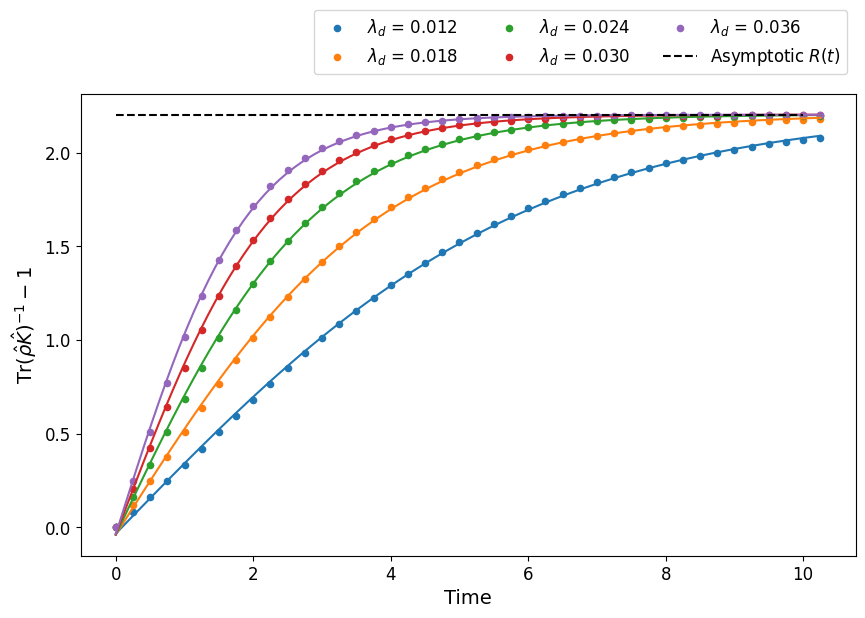

In [43]:
plt.figure(figsize=(10,6))
t_data = np.array(list(t_trotter)+[t_final+dt])

param_ratio_val = []
cov_ratio_val = []

xExpModel = np.linspace(min(t_data), max(t_data), 100)

for i in range(3,len(lam_list)):
    y_data = np.array([0.0]+list(np.array(trotter_noisy_ratio).reshape(len(lam_list),t_steps_trotter)[i]))

    poptexp, pcovexp = curve_fit(model_sigmoid, t_data, y_data)

    aapopt, bbopt, ddopt = poptexp
    
    param_ratio_val.append(bbopt)
    cov_ratio_val.append(np.sqrt(np.diag(pcovexp))[1])

    if i%3==0:
        plt.plot(xExpModel,model_sigmoid(xExpModel, aapopt, bbopt, ddopt))
        plt.scatter(t_data, y_data,label=rf'$\lambda_d$ = {lam_list[i]:.3f}',s=20)

plt.hlines(2.2,0,10,linestyles='dashed',color='k',label=r'Asymptotic $R(t)$')
plt.xlabel('Time',size=14)
plt.ylabel(r'Tr($\hat{\rho}\hat{K}$)$^{-1}-1$',size=14)
plt.legend(fontsize=12,bbox_to_anchor=(1.0, 1.2), ncol=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()